In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
from jax import grad
from jax import jit, grad, jacfwd, jacrev
import math


import scipy 

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]
plt.style.use('default')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})


from tqdm import tqdm
import time

from jax.config import config
config.update("jax_enable_x64", True)

import sys
HOME = "/Users/daniellengyel/curr_adventure/exact_sampling"
sys.path.append(HOME)

from Ours import Ours
from FD import FD
from Functions import Quadratic, PyCutestGetter
from RBF import RBF

from scipy.interpolate import Rbf, RBFInterpolator

%load_ext autoreload
%autoreload 2

In [52]:
func_name = "ARWHEAD"
dim = 100
sig = 0.1
_, x_init, F = PyCutestGetter(func_name=func_name, func_dim=dim, func_i=None, dim_i=None, sig=0, noise_type="gaussian")

In [3]:
F.f(jnp.ones(dim))

297.0

In [59]:
import jax.numpy as jnp
from jax import grad
from jax import random as jrandom
import time
from tqdm import tqdm 

from jax import jit, grad, jacfwd
from scipy.interpolate import Rbf, RBFInterpolator


from jax.config import config
config.update("jax_enable_x64", True)

class OptimizationBlueprint:
    def __init__(self, x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_eps=0, verbose=False, x_opt=None):
        self.jrandom_key = jrandom_key

        self.step_size = step_size

        self.sig = sig

        self.F = F

        self.loop_steps_remaining = num_total_steps
        self.num_total_steps = num_total_steps
        self.grad_eps = grad_eps

        self.verbose = True
        self.x_init = x_init
        self.dim = len(x_init)
        self.verbose = verbose

        self.x_opt = x_opt
         

    def run_opt(self):
        X = self.x_init

        vals_arr = []
        x_arr = []
        total_func_calls = 0
        start_time = time.time()

        vals_arr.append((self.F.f(X), time.time() - start_time, total_func_calls, 0))
        x_arr.append(X)

        for t in tqdm(range(self.loop_steps_remaining)):

            
            # get search direction
            if self.jrandom_key is not None:
                self.jrandom_key, subkey = jrandom.split(self.jrandom_key)
                search_direction, f1, num_func_calls = self.step_getter(X, subkey)
            else:
                search_direction, f1, num_func_calls = self.step_getter(X)
            total_func_calls += num_func_calls

            vals_arr.append((self.F.f(X), time.time() - start_time, total_func_calls, float(jnp.linalg.norm(f1 - self.F.f1(X))))) # jnp.linalg.norm(X - self.F.x_opt))) #float(f1.T @ self.F.f1(X)) / (jnp.linalg.norm(self.F.f1(X)) * jnp.linalg.norm(f1))))#  float(jnp.linalg.norm(f1 - self.F.f1(X)))/jnp.linalg.norm(self.F.f1(X))))# jnp.linalg.norm(X - self.x_init)))# # jnp.linalg.norm(self.F.f1(X)))) # #float(jnp.linalg.norm(self.grad_curr - self.F.f1(X))/jnp.linalg.norm(self.F.f1(X))))) #/jnp.linalg.norm(self.F.f1(X))))) jnp.linalg.norm(alpha * search_direction))) #
            x_arr.append(X)

            if jnp.linalg.norm(f1)/self.dim < self.grad_eps:
                break

            if self.verbose:
                # print(X)
                print("Number Iterations", t)
                print("Num Function Calls", total_func_calls)
                print("Obj", self.F.f(X))
                print("Grad norm", jnp.linalg.norm(f1))
                print("True Norm", jnp.linalg.norm(self.F.f1(X)))
                print()

            if self.F.f(X) == float("inf"):
                break
            
            # update step
            X = X + self.step_size * search_direction

            if vals_arr[-1][-1] > 1e10:
                break

        return X, jnp.array(vals_arr), jnp.array(x_arr)


    def step_getter(self, X, jrandom_key=None):
        pass


class NewtonMethod(OptimizationBlueprint):
    def __init__(self, x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_eps=0, verbose=False):
        super().__init__(x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_eps, verbose)
        self.sig = 0
        self.grad_curr = None
    
    def step_getter(self, X, jrandom_key=None):
        f1 = self.F.f1(X)
        f2 = self.F.f2(X)
        self.grad_curr = f1
        return -jnp.linalg.inv(f2).dot(f1), f1, 2

class GradientDescent(OptimizationBlueprint):
    def __init__(self, x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_eps=0, verbose=False):
        super().__init__(x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_eps, verbose)
        self.sig = 0
        self.grad_curr = None
    
    def step_getter(self, X, jrandom_key=None):
        f1 = self.F.f1(X)
        self.grad_curr = f1
        return -f1, f1, 2 


class ExactH_GD(OptimizationBlueprint):
    def __init__(self, x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_getter, grad_eps=0, verbose=False):
        super().__init__(x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_eps, verbose)

        self.grad_getter = grad_getter
        

    def step_getter(self, X, jrandom_key):
        num_func_calls = 0
        
        H = self.F.f2(X)
        f1, num_func_calls, _, _, _ = self.grad_getter.grad(self.F, X, jrandom_key, H=H)

        if self.verbose:
            print("Grad diff", jnp.linalg.norm(f1 - self.F.f1(X))/jnp.linalg.norm(self.F.f1(X)))

        return -f1, f1, num_func_calls



class InterpH_GD(OptimizationBlueprint):
    def __init__(self, x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_getter, grad_eps=0, verbose=False, smoothing=1):
        super().__init__(x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_eps, verbose)


        self.X_prev = None
        self.grad_curr = None
        self.grad_getter = grad_getter
        
        self.interp_points = None
        self.F_vals = None
        
        self.smoothing = smoothing
        

    def step_getter(self, X, jrandom_key):
        num_func_calls = 0
        if (self.interp_points is not None) and (self.interp_points.shape[1] > 2 * len(X) + 1):
            curr_interp_points = []
            curr_F_vals = []
            
            curr_interp_points = self.interp_points[:, -1000:] # int(-self.dim**2 * 2):]# self.interp_points # jnp.array(curr_interp_points).T # 
            curr_F_vals = self.F_vals[-1000:] # [-int(self.dim**2 * 2): ] # self.F_vals # jnp.array(curr_F_vals) # 
            
            curr_rbf = RBF(curr_interp_points, curr_F_vals, self.smoothing)
            H, rbf_f1 = curr_rbf.f2(X), curr_rbf.f1(X)
#             print(repr(H))
#             print(jnp.linalg.cond(H))
#             print("grad diff", jnp.linalg.norm(rbf_f1 - self.F.f1(X))/jnp.linalg.norm(self.F.f1(X)))
#             print("H diff", jnp.linalg.norm(H - self.F.f2(X))/jnp.linalg.norm(self.F.f2(X)))

        else:
            H = jnp.eye(len(X))
            rbf_f1 = None

        self.grad_curr, num_func_calls, F_x_0, FS, S = self.grad_getter.grad(self.F, X, jrandom_key, H=H)
#         print("Grad diff", jnp.linalg.norm(self.grad_curr - self.F.f1(X))/jnp.linalg.norm(self.F.f1(X)))

        if self.interp_points is None:
            self.interp_points = jnp.concatenate([S + X.reshape(-1, 1), X.reshape(-1, 1)], axis=1)
            self.F_vals = jnp.concatenate([FS, jnp.array([F_x_0])])
        else:
            self.interp_points = jnp.concatenate([self.interp_points, S + X.reshape(-1, 1), X.reshape(-1, 1)], axis=1)
            self.F_vals = jnp.concatenate([self.F_vals, FS, jnp.array([F_x_0])])
        
        if self.verbose:

            print("Grad diff", jnp.linalg.norm(self.grad_curr - self.F.f1(X))/jnp.linalg.norm(self.F.f1(X)))
#             print("H diff", jnp.linalg.norm(H - self.F.f2(X))/jnp.linalg.norm(self.F.f2(X)))
            # print("H eigs", (jnp.linalg.eigh(H)[0] - jnp.linalg.eigh(self.F.f2(X))[0])/jnp.linalg.eigh(self.F.f2(X))[0])
            
        f1 = self.grad_curr

        return -f1, f1, num_func_calls
    
    



In [73]:
grad_getter_our = Ours(sig, max_h=0.025)
grad_getter_fd = FD(sig, is_central=False, h=0.005)


step_size = 0.001
num_total_steps = 20
jrandom_key = jrandom.PRNGKey(0)

smoothing = 0.1
# X_final, l_hist_1, x_path = ExactH_GD(x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_getter_our, grad_eps=0, verbose=False).run_opt()
# X_final, l_hist_2, x_path = ExactH_GD(x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_getter_fd, grad_eps=0, verbose=False).run_opt()
X_final, l_hist_1, x_path = InterpH_GD(x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_getter_our, grad_eps=0, verbose=False, smoothing=smoothing).run_opt()
X_final, l_hist_2, x_path = InterpH_GD(x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_getter_fd, grad_eps=0, verbose=False, smoothing=smoothing).run_opt()



# X_final, l_hist_2, x_path = InterpH_GD(x_init, F, step_size, num_total_steps, sig, jrandom_key, grad_getter, grad_eps=0, verbose=False, smoothing=0.01).run_opt()




100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  9.87it/s]


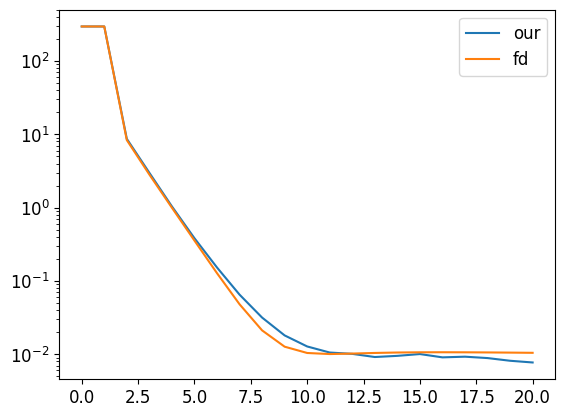

In [74]:
plt.plot(l_hist_1[:, 0], label="our")
plt.plot(l_hist_2[:, 0], label="fd")
plt.yscale("log")
plt.legend()